In [1]:
import qtensor
import numpy as np
import torch

from circuit_11 import circuit_11, get_circ_and_peo

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
N = 8
FIXED = 4
LAYERS = 3

## Read eignestates

In [4]:
from pathlib import Path
def read_eigenstate(L=8, delta=0):
    data_path = Path(f'../data/XXZ_L{L}/')
    filename = f'XXZwavedeltadelta_{L}_{delta}.npy'
    return np.load(data_path/filename)

In [5]:
read_eigenstate().shape

(256, 1)

In [38]:
import qtree
class InitSim(qtensor.QtreeSimulator):
    def set_init_state(self, state):
        self.init_state = state

    def _create_buckets(self):
        self.tn = qtensor.optimisation.QtreeTensorNet.from_qtree_gates(
            self.all_gates, init_state=self.init_state, backend=self.backend,
        )
        self.tn.backend = self.backend

    def _get_slice_dict(self, initial_state=0, target_state=0):
        slice_dict = {}
        slice_dict.update(qtree.utils.slice_from_bits(target_state, self.tn.bra_vars))
        slice_dict.update(qtree.utils.slice_from_bits(target_state, self.tn.bra_vars))
        slice_dict.update({var: slice(None) for var in self.tn.free_vars})
        slice_dict.update({var: slice(None) for var in self.tn.ket_vars})
        return slice_dict

In [39]:
sim = InitSim(backend=qtensor.contraction_backends.get_backend('torch'))

In [116]:
parameters = 2*np.pi*torch.rand(LAYERS*(4*N - 4), requires_grad=True)
parameters.retain_grad()
parameters

tensor([4.6364, 4.5428, 1.5382, 0.9449, 6.1108, 2.4651, 4.4485, 0.8780, 5.3159,
        0.1547, 3.2637, 5.3338, 0.0099, 0.6378, 2.6495, 4.4971, 4.7221, 0.4612,
        3.6766, 4.4082, 6.1660, 3.9588, 2.4845, 0.5251, 2.4232, 0.7866, 5.4962,
        4.8549, 4.3219, 1.9596, 5.8828, 3.5695, 4.3269, 4.9607, 1.8645, 1.3474,
        2.2648, 1.4038, 0.4491, 2.9762, 3.2542, 1.5775, 0.7192, 2.2991, 0.6314,
        2.8734, 5.8013, 3.2864, 0.6413, 1.9607, 5.2508, 2.8097, 2.9088, 3.7419,
        1.6706, 4.3114, 4.4432, 4.6854, 5.8985, 0.9408, 0.9718, 4.4480, 6.0973,
        1.1357, 5.2387, 4.8226, 6.0772, 2.4298, 4.4570, 1.3613, 3.5242, 4.9890,
        5.8758, 4.9264, 2.0256, 4.8341, 5.6734, 0.1671, 3.1953, 4.5778, 0.2276,
        5.4632, 0.0801, 2.9252], grad_fn=<MulBackward0>)

In [127]:
train_size = 2
train_set = [
    read_eigenstate(L=N, delta=i) for i in range(train_size)
]

In [128]:
def amps2loss(amps):
    return -torch.abs(amps*torch.conj(amps)).sum()

In [203]:
steps = 150
lr = 0.05
stop_epsilon = 1e-12

In [204]:
peo, circ = get_circ_and_peo(parameters, N=N, layers=LAYERS, fixed=FIXED)
loss_prev = np.inf
for i in range(steps):
    
    loss = torch.tensor(0.)
    for train_x in train_set:
        sim.set_init_state(train_x)
        amps = sim.simulate_batch(circ, peo=peo, batch_vars=range(FIXED, N))
        loss += amps2loss(amps)
        
    loss /= len(train_set)
    loss.backward(retain_graph=True)
    with torch.no_grad():
        parameters -= lr*parameters.grad
    print('loss=', loss.data, 'sum_grad=', np.abs(parameters.grad.detach().numpy().sum()))
    
    if abs((loss_prev - loss.data.numpy())/loss.data) < stop_epsilon:
        print(f'Reached convergence after {i} steps!')
        break
    #print(amps.data, np.abs(np.square(amps.detach().numpy())))
    loss_prev = loss.data
    parameters.grad.zero_()
    

loss= tensor(-0.9988) sum_grad= 0.0018221143
loss= tensor(-0.9988) sum_grad= 0.0008758935
loss= tensor(-0.9988) sum_grad= 0.0008562565
loss= tensor(-0.9988) sum_grad= 0.0008452759
loss= tensor(-0.9988) sum_grad= 0.00084216776
loss= tensor(-0.9988) sum_grad= 0.00082307693
loss= tensor(-0.9988) sum_grad= 0.0008144086
loss= tensor(-0.9988) sum_grad= 0.0007820516
loss= tensor(-0.9988) sum_grad= 0.0007731083
loss= tensor(-0.9988) sum_grad= 0.0007783182
loss= tensor(-0.9988) sum_grad= 0.0007475766
loss= tensor(-0.9988) sum_grad= 0.0007473343
loss= tensor(-0.9988) sum_grad= 0.00073357124
loss= tensor(-0.9988) sum_grad= 0.0007156365
loss= tensor(-0.9988) sum_grad= 0.0007078784
loss= tensor(-0.9988) sum_grad= 0.0007004903
loss= tensor(-0.9988) sum_grad= 0.0006859797
loss= tensor(-0.9988) sum_grad= 0.00067163754
loss= tensor(-0.9988) sum_grad= 0.00067789445
loss= tensor(-0.9988) sum_grad= 0.00064364466
loss= tensor(-0.9988) sum_grad= 0.00063947355
loss= tensor(-0.9988) sum_grad= 0.0006319865
Rea

## Test results

In [205]:
import matplotlib.pyplot as plt
test_sim = InitSim()

In [206]:
def get_compression(delta):
    """
    Returns:
        original_state, compressed_state
    """
    state = read_eigenstate(delta=delta)
    test_sim.set_init_state(state)
    peo, circ = get_circ_and_peo(parameters.detach().numpy(), N=N,
                                 layers=LAYERS, fixed=FIXED, backend='numpy')
    amps_np = test_sim.simulate_batch(circ, peo=peo, batch_vars=N)
    return state.flatten(), amps_np
    

In [207]:
compression = get_compression(delta=3)

In [208]:
def plot_state(state):
    probs = np.abs(state*state).flatten()
    plt.bar(range(len(probs)), probs)

In [209]:
def compare_compression(orig_state, compressed_state):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plt.sca(axs[0])
    plot_state(orig_state)
    plt.sca(axs[1])
    plot_state(compressed_state)
    

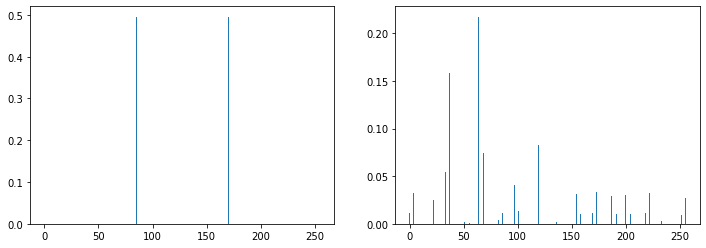

In [100]:
compare_compression(*compression)

### Look at all test

In [210]:
compressions = [get_compression(delta=i) for i in range(len(train_set))]    

[None, None]

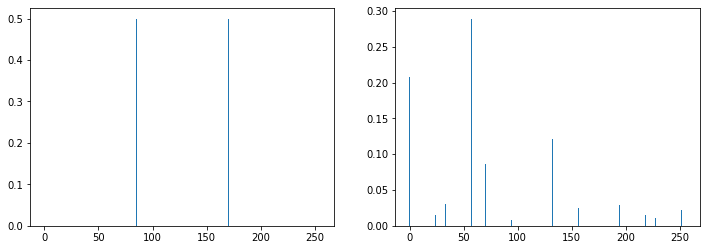

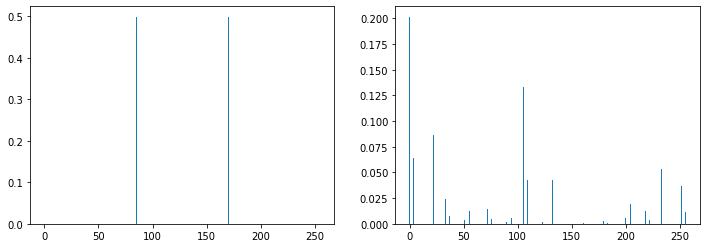

In [211]:
[compare_compression(*i) for i in compressions]

In [ ]:
compressed